# 7.0 - Expected Pitch Effectiveness
Modeling expected pitch effectiveness based on situation (count, handedness, etc) to understand pitch usage and performance.

## Libraries

In [1]:
import logging
import sys
import warnings

import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    DiscriminationThreshold
)

## Setup

In [2]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [4]:
# BigQuery
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [5]:
# Pandas
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [6]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

## Data

In [7]:
params = {
    'min_year': 2016
}

In [8]:
SQL = \
"""
SELECT
  t_event.*,
  t_player.mlb_name AS pitcher_name
FROM
  (
    SELECT
      event_id,
      MAX(game_year) AS game_year,
      MAX(pitcher) AS pitcher_id,
      MAX(p_throws) AS pitcher_hand,
      MAX(stand) AS batter_hand,
      MAX(balls) AS balls,
      MAX(strikes) AS strikes,
      CONCAT(CAST(MAX(balls) AS STRING), '-', CAST(MAX(strikes) AS STRING)) AS count,
      MAX(pitch_type) AS pitch_type,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(estimated_woba_using_speedangle) AS estimated_woba_using_speedangle,
      MAX(woba_value) AS woba_value,
      MAX(woba_denom) AS woba_denom
    FROM
      `ad-fantasy-baseball.core.statcast_extended`
    WHERE
      game_year >= {min_year}
        AND description NOT IN (
          'foul_bunt',
          'hit_by_pitch',
          'intent_ball',
          'missed_bunt',
          'pitchout',
          'bunt_foul_tip',
          'swinging_pitchout',
          'foul_pitchout',
          'pitchout_hit_into_play',
          'pitchout_hit_into_play_score'
        )
    GROUP BY 1
  ) t_event
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_player
    ON (t_event.pitcher_id = t_player.mlb_id)
"""

In [9]:
sql_base = SQL.format(**params)
df_base = read_gbq(
    query=sql_base,
    dialect='standard',
    project_id=PROJECT_ID,
    private_key=CREDENTIALS_PATH,
    configuration={'query': {'useQueryCache': False}}
)

df_copy = df_base.copy()

Requesting query... 
ok.
Query running...
Job ID: 19bd9ebc-c029-410f-ad96-5d4f8511223b
Query running...
  Elapsed 9.1 s. Waiting...
  Elapsed 10.23 s. Waiting...
  Elapsed 12.48 s. Waiting...
  Elapsed 14.5 s. Waiting...
  Elapsed 15.54 s. Waiting...
  Elapsed 16.58 s. Waiting...
  Elapsed 17.63 s. Waiting...
Got 2533662 rows.

Total time taken 426.33 s.
Finished at 2019-06-15 12:54:20.


In [35]:
df_base.head()

,event_id,game_year,pitcher_id,pitcher_hand,batter_hand,balls,strikes,count,pitch_type,description,events,estimated_woba_using_speedangle,woba_value,woba_denom,pitcher_name,flag_strike,flag_contact,flag_swstr,flag_cstr,flag_00,flag_01,flag_02,flag_10,flag_11,flag_12,flag_20,flag_21,flag_22,flag_30,flag_31,flag_32,flag_platoon,pred_swstr
11,565801.58.1,2019,628317,R,L,0,0,0-0,FF,ball,None,NaN,NaN,NaN,Kenta Maeda,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061321
12,565803.54.1,2019,571670,R,R,0,0,0-0,SL,called_strike,None,NaN,NaN,NaN,Dylan Floro,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0.070294
13,565804.3.1,2019,547943,L,R,0,0,0-0,FF,foul,None,NaN,NaN,NaN,Hyun-Jin Ryu,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061321
14,565804.68.1,2019,445276,R,L,0,0,0-0,FC,called_strike,None,NaN,NaN,NaN,Kenley Jansen,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061321
15,565805.19.1,2019,548389,R,L,0,0,0-0,FF,called_strike,None,NaN,NaN,NaN,Ross Stripling,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061321


## Data prep

In [55]:
# Remove bad data
df_base = df_base[df_base['balls'] < 4]
df_base = df_base[df_base['strikes'] < 3]

In [56]:
# Data formatting
numeric_cols = [
    'balls',
    'strikes',
    'estimated_woba_using_speedangle',
    'woba_value',
    'woba_denom'
]

df_base[numeric_cols] = df_base[numeric_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [57]:
# Outcome filters
outcomes_strike = [
    'called_strike',
    'swinging_strike',
    'swinging_strike_blocked',
    'missed_bunt'
]
outcomes_swinging_strike = [
    'swinging_strike',
    'swinging_strike_blocked',
    'missed_bunt'
]
outcomes_ball = [
    'ball',
    'blocked_ball',
    'pitchout',
    'hit_by_pitch'
]
outcomes_contact = [
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip',
    'foul_bunt'
]
outcomes_swing = [
    'swinging_strike',
    'swinging_strike_blocked',
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip'
]

_pitcher_r = df_base['pitcher_hand'] == 'R'
_batter_r = df_base['batter_hand'] == 'R'
_strike = df_base['description'].isin(outcomes_strike)
_ball = df_base['description'].isin(outcomes_ball)
_contact = df_base['description'].isin(outcomes_contact)
_swing = df_base['description'].isin(outcomes_swing)

In [58]:
df_base['flag_strike'] = np.where(df_base['description'].isin(outcomes_strike), 1, 0)
df_base['flag_contact'] = np.where(df_base['description'].isin(outcomes_contact), 1, 0)
df_base['flag_swstr'] = np.where(df_base['description'].isin(outcomes_swinging_strike), 1, 0)
df_base['flag_cstr'] = np.where(df_base['description'] == 'called_strike', 1, 0)

df_base['flag_00'] = np.where(df_base['count'] == '0-0', 1, 0)
df_base['flag_01'] = np.where(df_base['count'] == '0-1', 1, 0)
df_base['flag_02'] = np.where(df_base['count'] == '0-2', 1, 0)
df_base['flag_10'] = np.where(df_base['count'] == '1-0', 1, 0)
df_base['flag_11'] = np.where(df_base['count'] == '1-1', 1, 0)
df_base['flag_12'] = np.where(df_base['count'] == '1-2', 1, 0)
df_base['flag_20'] = np.where(df_base['count'] == '2-0', 1, 0)
df_base['flag_21'] = np.where(df_base['count'] == '2-1', 1, 0)
df_base['flag_22'] = np.where(df_base['count'] == '2-2', 1, 0)
df_base['flag_30'] = np.where(df_base['count'] == '3-0', 1, 0)
df_base['flag_31'] = np.where(df_base['count'] == '3-1', 1, 0)
df_base['flag_32'] = np.where(df_base['count'] == '3-2', 1, 0)

df_base['flag_platoon'] = np.where(df_base['pitcher_hand'] == df_base['batter_hand'], 1, 0)

In [59]:
df_base.head()

,event_id,game_year,pitcher_id,pitcher_hand,batter_hand,balls,strikes,count,pitch_type,description,events,estimated_woba_using_speedangle,woba_value,woba_denom,pitcher_name,flag_strike,flag_contact,flag_swstr,flag_cstr,flag_00,flag_01,flag_02,flag_10,flag_11,flag_12,flag_20,flag_21,flag_22,flag_30,flag_31,flag_32,flag_platoon,pred_swstr
11,565801.58.1,2019,628317,R,L,0,0,0-0,FF,ball,None,NaN,NaN,NaN,Kenta Maeda,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061265
12,565803.54.1,2019,571670,R,R,0,0,0-0,SL,called_strike,None,NaN,NaN,NaN,Dylan Floro,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0.070196
13,565804.3.1,2019,547943,L,R,0,0,0-0,FF,foul,None,NaN,NaN,NaN,Hyun-Jin Ryu,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061265
14,565804.68.1,2019,445276,R,L,0,0,0-0,FC,called_strike,None,NaN,NaN,NaN,Kenley Jansen,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061265
15,565805.19.1,2019,548389,R,L,0,0,0-0,FF,called_strike,None,NaN,NaN,NaN,Ross Stripling,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.061265


## Modeling

In [60]:
def train_and_evaluate_model(
        df,
        label,
        features,
        model,
        test_size=0.15,
        decision_threshold=0.5,
        discrimination_plot=False
    ):
    
    # Train model
    y = df[label]
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred_proba = [ y[1] for y in model.predict_proba(X_test) ]
    y_pred = [ 1 if y > decision_threshold else 0 for y in y_pred_proba]
    
    # Model description
    model_name = type(model).__name__
    
    if model_name in ['LogisticRegression']:
        print('MODEL COEFFICIENTS FOR {:s} MODEL'.format(model_name))
        
        intercept = model.intercept_[0]
        if intercept > 0:
            print("{:30}[{:5.3f}]".format('Intercept:', intercept))
        
        for feature, weight in list(zip(features, model.coef_[0])):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
                
    # Model metrics
    prs = precision_score(y_test, y_pred)
    res = recall_score(y_test, y_pred)
    acs = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('MODEL METRICS FOR {:s} MODEL'.format(model_name))
    print('Precision Score: {:5.4f}'.format(prs))
    print('Recall Score: {:5.4f}'.format(res))
    print('Accuracy Score: {:5.4f}'.format(acs))
    print('F1 Score: {:5.4f}'.format(f1))
    
    print('\nCONFUSION MATRIC FOR {:s} MODEL'.format(model_name))
    print(confusion_matrix(y_test, y_pred))
    
    # Classification Report
    class_report = ClassificationReport(model)
    class_report.fit(X_train, y_train)
    class_report.score(X_test, y_test)
    class_report.poof()

    # ROC AUC
    rocauc = ROCAUC(model)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    # Class Prediction Error Report
    cpe_report = ClassPredictionError(model)
    cpe_report.fit(X_train, y_train)
    cpe_report.score(X_test, y_test)
    cpe_report.poof()
    
    # Discrimination Threshold Curve
    if discrimination_plot:
        dt_curve = DiscriminationThreshold(model)
        dt_curve.fit(X_train, y_train)
        dt_curve.poof()

MODEL COEFFICIENTS FOR LogisticRegression MODEL
flag_00:                      [-0.5455]
flag_01:                      [0.0779]
flag_02:                      [0.2380]
flag_10:                      [-0.1694]
flag_11:                      [0.1285]
flag_12:                      [0.2861]
flag_20:                      [-0.3175]
flag_21:                      [0.0949]
flag_22:                      [0.2496]
flag_30:                      [-2.0807]
flag_31:                      [-0.1994]
flag_32:                      [0.0944]
flag_platoon:                 [0.1275]


MODEL METRICS FOR LogisticRegression MODEL
Precision Score: 0.1285
Recall Score: 0.7459
Accuracy Score: 0.4328
F1 Score: 0.2192

CONFUSION MATRIC FOR LogisticRegression MODEL
[[134239 205238]
 [ 10309  30262]]


/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


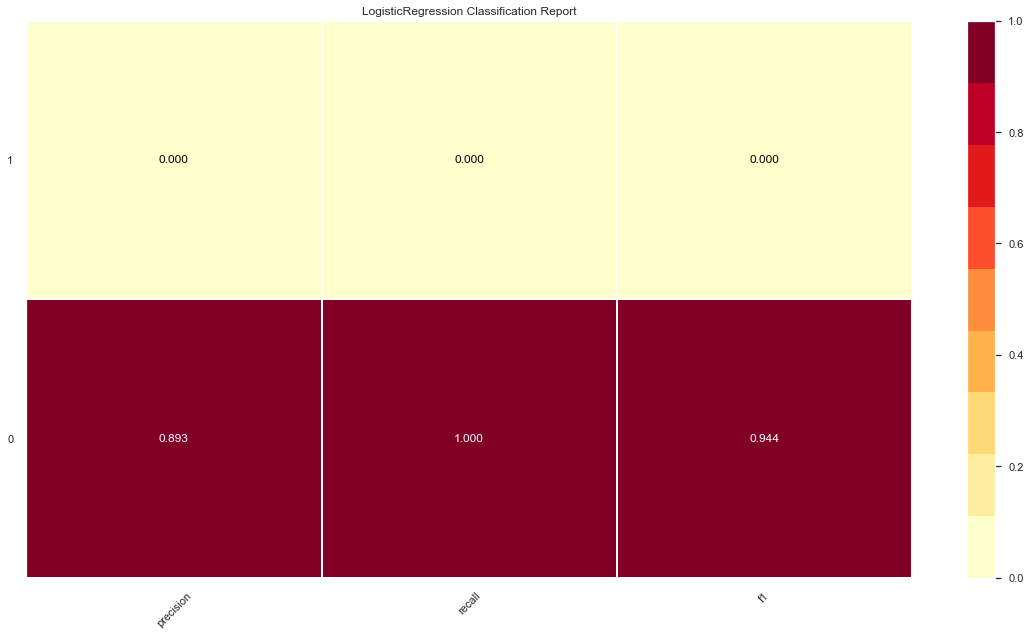

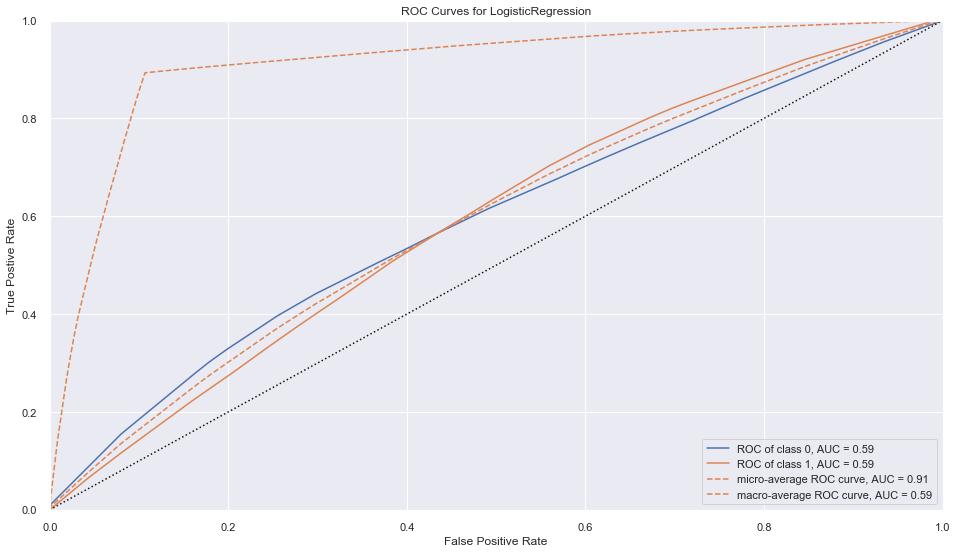

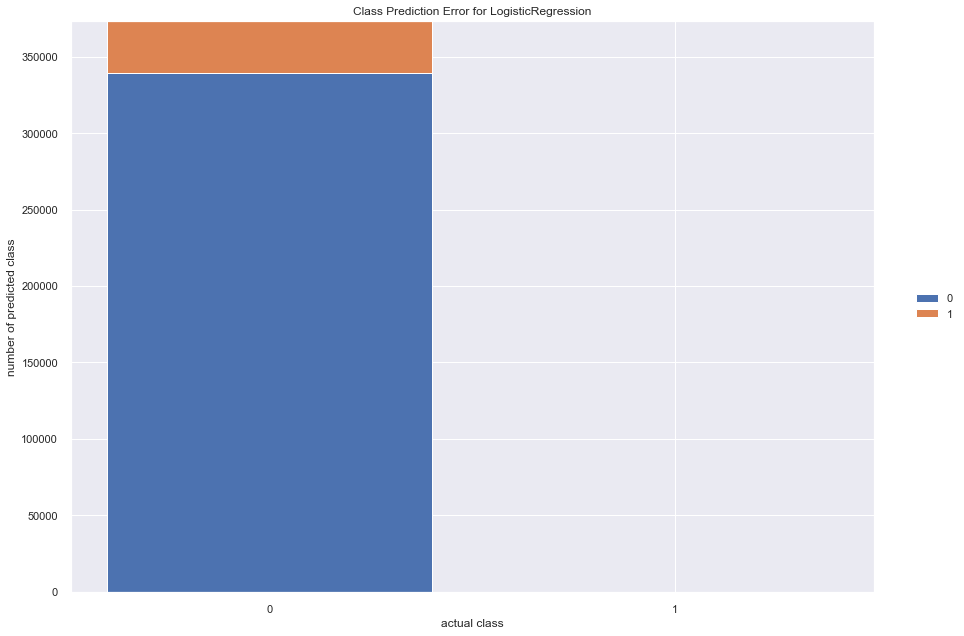

In [61]:
lr_label = 'flag_swstr'
lr_classes = ['contact', 'swinging_strike']
lr_features = [
    'flag_00',
    'flag_01',
    'flag_02',
    'flag_10',
    'flag_11',
    'flag_12',
    'flag_20',
    'flag_21',
    'flag_22',
    'flag_30',
    'flag_31',
    'flag_32',
    'flag_platoon'
]
lr_model = LogisticRegression(
    fit_intercept=True
)

train_and_evaluate_model(
    df=df_base,
    label=lr_label,
    features=lr_features,
    model=lr_model,
    decision_threshold=0.1
)

In [98]:
# Predict specific situations
lr_model.predict_proba(X=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

array([[0.88582946, 0.11417054]])

## Analysis

In [63]:
# Apply model(s) to pitch-level data
df_pred_lr = df_base[lr_features]

df_base['pred_swstr'] = [ pred[1] for pred in lr_model.predict_proba(X=df_pred_lr)]

### Pitches since 2016

In [64]:
df_summary = df_base.groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_swstr': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'swstr'
})

df_summary['delta_swstr'] = df_summary['swstr'] - df_summary['pred_swstr']

In [65]:
df_summary[df_summary['pitches'] > 100].sort_values(by=['pred_swstr'], ascending=False).head(10)

,,,pitches,swstr,pred_swstr,delta_swstr
pitcher_id,pitcher_name,pitch_type,,,,
448306,James Shields,EP,205,0.190244,0.137390,0.052854
476454,Dellin Betances,SL,394,0.203046,0.137243,0.065802
434671,Anibal Sanchez,CH,242,0.206612,0.131331,0.075281
657610,Trevor Hildenberger,FF,149,0.080537,0.131304,-0.050768
518553,Steve Cishek,FF,255,0.172549,0.131257,0.041292
467100,Ivan Nova,FC,143,0.195804,0.131212,0.064592
607192,Tyler Glasnow,SL,172,0.261628,0.130991,0.130637
545333,Trevor Bauer,SL,636,0.209119,0.130925,0.078194
445276,Kenley Jansen,SL,296,0.229730,0.129294,0.100436


In [66]:
# Summary filters
_cutoff = df_summary['pitches'] > 100

df_summary_f = df_summary[_cutoff]

Text(0.5,1,'SwStr % over expectation as a function of predicted SwStr %, since 2016')

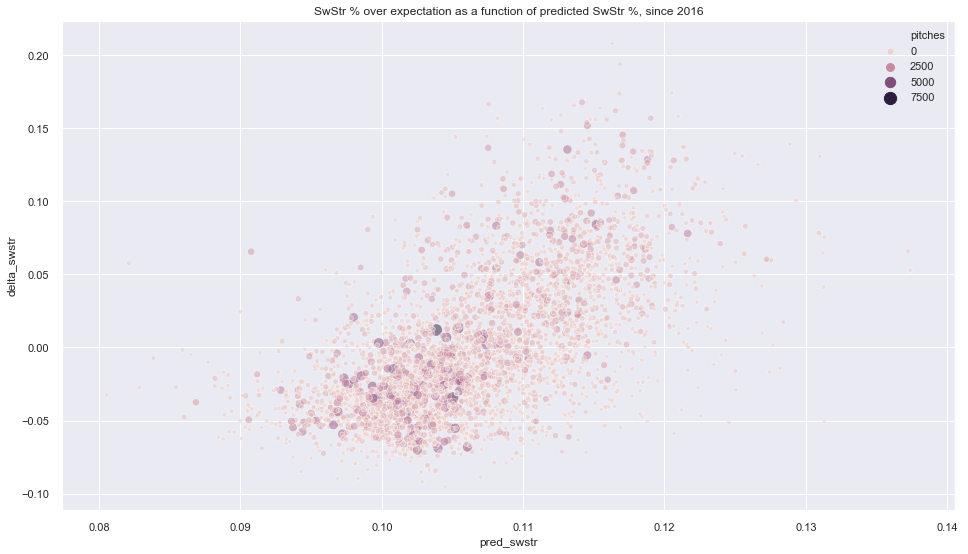

In [101]:
sns.scatterplot(
    x=df_summary_f['pred_swstr'],
    y=df_summary_f['delta_swstr'],
    hue=df_summary_f['pitches'],
    size=df_summary_f['pitches'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of predicted SwStr %, since 2016')

Text(0.5,1,'SwStr % over expectation as a function of pitch count, since 2016')

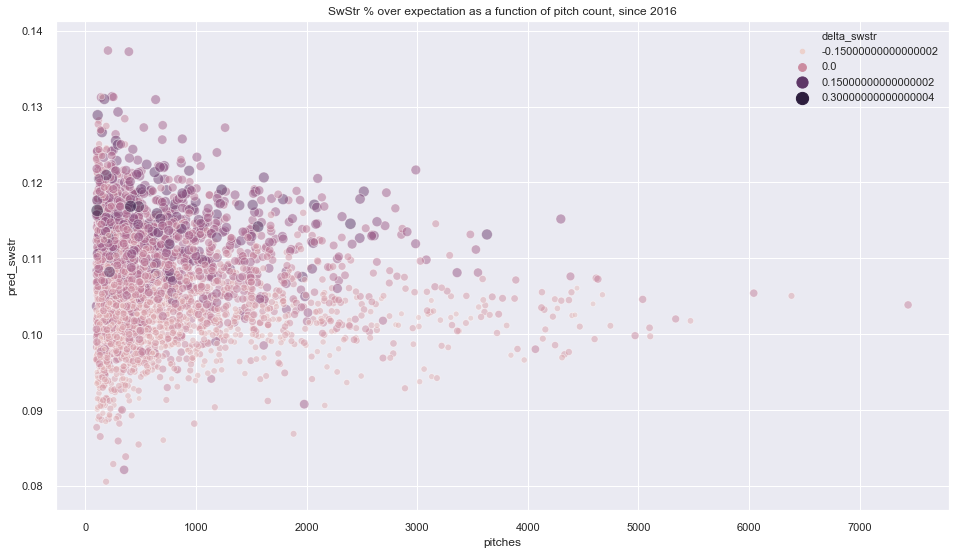

In [102]:
sns.scatterplot(
    x=df_summary_f['pitches'],
    y=df_summary_f['pred_swstr'],
    hue=df_summary_f['delta_swstr'],
    size=df_summary_f['delta_swstr'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of pitch count, since 2016')

### Pitches in 2019

In [69]:
df_year_2019 = df_base[df_base['game_year'] == 2019].groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_swstr': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'swstr'
})

df_year_2019['delta_swstr'] = df_year_2019['swstr'] - df_year_2019['pred_swstr']

In [70]:
df_year_2019[df_year_2019['pitches'] > 50].sort_values(by=['swstr'], ascending=False).head(10)

,,,pitches,swstr,pred_swstr,delta_swstr
pitcher_id,pitcher_name,pitch_type,,,,
663432,Tanner Rainey,SL,62,0.370968,0.113508,0.257460
669203,Corbin Burnes,SL,192,0.369792,0.118771,0.251021
628452,Raisel Iglesias,CH,107,0.327103,0.119765,0.207338
596112,Robert Stephenson,SL,214,0.322430,0.110199,0.212231
571760,Andrew Heaney,CU,108,0.305556,0.121389,0.184167
592454,Tommy Kahnle,CH,189,0.296296,0.113495,0.182802
608648,Tyler Duffey,SL,78,0.294872,0.126641,0.168231
623352,Josh Hader,SL,51,0.294118,0.124812,0.169306
572362,Robbie Erlin,CH,82,0.292683,0.114910,0.177773


In [71]:
# Summary filters
_cutoff_year = df_year_2019['pitches'] > 50

df_year_2019_f = df_year_2019[_cutoff_year]

Text(0.5,1,'SwStr % over expectation as a function of predicted SwStr %, 2019')

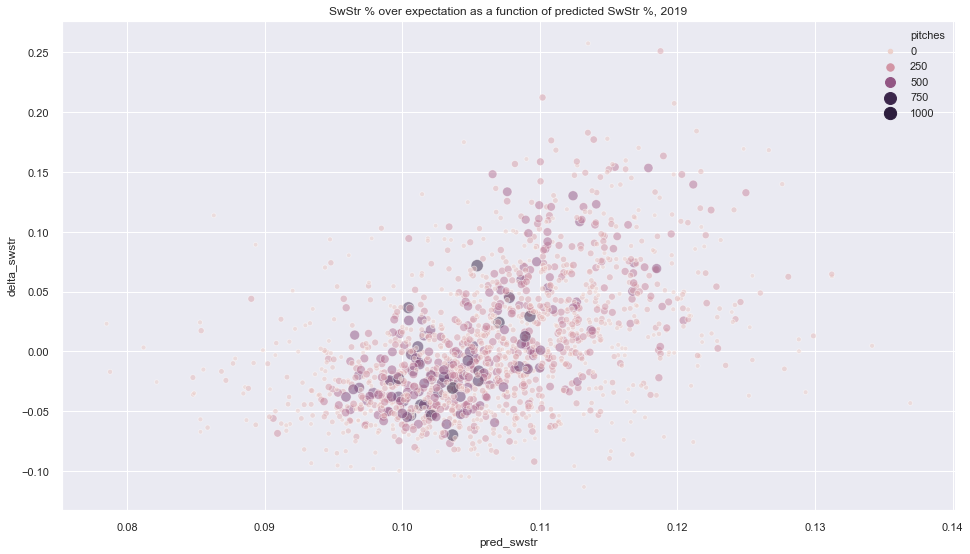

In [100]:
sns.scatterplot(
    x=df_year_2019_f['pred_swstr'],
    y=df_year_2019_f['delta_swstr'],
    hue=df_year_2019_f['pitches'],
    size=df_year_2019_f['pitches'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of predicted SwStr %, 2019')

Text(0.5,1,'SwStr % over expectation as a function of pitch count, 2019')

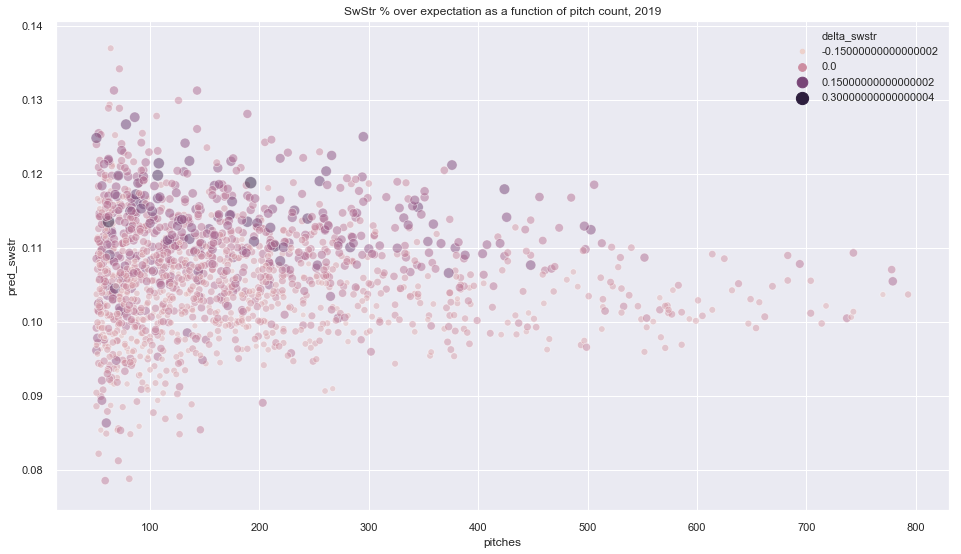

In [103]:
sns.scatterplot(
    x=df_year_2019_f['pitches'],
    y=df_year_2019_f['pred_swstr'],
    hue=df_year_2019_f['delta_swstr'],
    size=df_year_2019_f['delta_swstr'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of pitch count, 2019')

### Export data

In [74]:
df_year_2019.to_csv('~/Desktop/expected_swstr_2019.csv')
df_summary.to_csv('~/Desktop/expected_swstr_all_time.csv')